<a href="https://colab.research.google.com/github/dharmesh312/AI-Course/blob/master/aiass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.examples.tutorials.mnist import input_data


In [0]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

test_data_images  = mnist.test.images
train_data_images = mnist.train.images
valid_data_images = mnist.validation.images

test_data_labels  = mnist.test.labels
train_data_labels = mnist.train.labels
valid_data_labels = mnist.validation.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:

!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
weightsAndBiases = {"Weights" : tf.Variable(tf.truncated_normal([784,500], mean = 0 ,stddev = 0.1))  , "hiddenBiases"  :  tf.Variable(tf.zeros(500)) , "visibleBiases"  :  tf.Variable(tf.zeros(784)) }
k = 20
lr = tf.placeholder(tf.float32)


In [0]:
def prop_up(visible):
		preSigmoidActivation = tf.matmul(visible, weightsAndBiases["Weights"]) + weightsAndBiases["hiddenBiases"]
		return tf.nn.sigmoid(preSigmoidActivation)
  

def prop_down(hidden):
		preSigmoidActivation = tf.matmul(hidden, tf.transpose(weightsAndBiases["Weights"])) + weightsAndBiases["visibleBiases"]
		return tf.nn.sigmoid(preSigmoidActivation)

  
def sample_h_given_v(visible_sample):
		hidden_props = prop_up(visible_sample)
		hidden_sample = tf.nn.relu(tf.sign(hidden_props - tf.random_uniform(tf.shape(hidden_props))))
		return hidden_sample  
  
def sample_v_given_h(hidden_sample):
		visible_props = prop_down(hidden_sample)
		visible_sample = tf.nn.relu(tf.sign(visible_props - tf.random_uniform(tf.shape(visible_props))))
		return visible_sample  
  

def CD_k(visibles):       
		# k steps gibbs sampling
		visible_sample = visibles
		hidden_sample = sample_h_given_v(visible_sample)
		for i in range(k):
			visible_sample = sample_v_given_h(hidden_sample)
			hidden_sample = sample_h_given_v(visible_sample)
		
		h0_props = prop_up(visibles)
		w_positive_grad = tf.matmul(tf.transpose(visibles), h0_props)
		w_negative_grad = tf.matmul(tf.transpose(visible_sample), hidden_sample)
		w_grad = (w_positive_grad - w_negative_grad) / tf.to_float(tf.shape(visibles)[0])
		hb_grad = tf.reduce_mean(h0_props - hidden_sample, 0)
		vb_grad = tf.reduce_mean(visibles - visible_sample, 0)
		return w_grad, hb_grad, vb_grad  
  

def learn( visibles):
		w_grad, hb_grad, vb_grad = CD_k(visibles)
		# compute new velocities
		new_w_v =  lr * w_grad
		new_hb_v = lr * hb_grad
		new_vb_v = lr * vb_grad
		# update parameters
		update_w = tf.assign(weightsAndBiases["Weights"], weightsAndBiases["Weights"] + new_w_v)
		update_hb = tf.assign(weightsAndBiases["hiddenBiases"], weightsAndBiases["hiddenBiases"] + new_hb_v)
		update_vb = tf.assign(weightsAndBiases["visibleBiases"], weightsAndBiases["visibleBiases"] + new_vb_v)
		
		return [update_w, update_hb, update_vb]


def sampler(visibles, steps=2000):
		visible_sample = visibles
		for step in range(steps):
			visible_sample = sample_v_given_h(sample_h_given_v(visible_sample))
		return visible_sample

def free_energy( visibles):
		first_term = tf.matmul(visibles, tf.reshape(weightsAndBiases['visibleBiases'], [tf.shape(weightsAndBiases['visibleBiases'])[0], 1]))
		second_term = tf.reduce_sum(tf.log(1 + tf.exp(weightsAndBiases['hiddenBiases'] + tf.matmul(visibles, weightsAndBiases['Weights']))), axis=1)
		return - first_term - second_term  
  

flipping = 0  
def pseudo_likelihood(visibles,flipping):
		x = tf.round(visibles)
		x_fe = free_energy(x)
		split0, split1, split2 = tf.split(x, [flipping, 1, tf.shape(x)[1] - flipping - 1], 1)
		xi = tf.concat([split0, 1 - split1, split2], 1)
		flipping = (flipping + 1) % 784
		xi_fe = free_energy(xi)
		return tf.reduce_mean(784 * tf.log(tf.nn.sigmoid(xi_fe - x_fe)), axis=0)  
  

In [0]:
import scipy.misc

def save_images(images, size, path):
  img = (images + 1.0) / 2.0
  h, w = img.shape[1], img.shape[2]
  print (h,w)
  merge_img = np.zeros((h * size[0], w * size[1]))
  print (merge_img.shape)
  for idx, image in enumerate(images):
    i = idx % size[1]
    j = idx // size[1]
#     print(i,j)
    if  (i <8 and j < 8):
      merge_img[j*h:j*h+h, i*w:i*w+w] = image
  return scipy.misc.imsave(path, merge_img)


In [0]:
from sklearn.utils import shuffle

def train( epoches):
  # directories to save samples and logs
  
  # markov chain start state
  noise_x = test_data_images
  batch_size = 64

  # computation graph definition
  x = tf.placeholder(tf.float32, shape=[None, 784])
  step = learn(x)
  samplerObject = sampler(x)

  pl = pseudo_likelihood(x , flipping)

  saver = tf.train.Saver()
  
  with tf.Session() as sess:
    mean_cost = []
    costList = []
    epoch = 1
    init = tf.global_variables_initializer()
    sess.run(init)
    for l in range(epoches):
      # draw samples
      if l % 10 == 0:
        samples = sess.run(samplerObject, feed_dict = {x: noise_x})
        samples = samples.reshape([len(noise_x), 28, 28])
        save_images(samples, [8, 8], os.path.join("./drive/train", 'iteration_%d.png' % l))
#         print('Saved samples.')
      
      for j in range(int(mnist.train.num_examples / batch_size)):
        batch_x , batch_y = mnist.train.next_batch(batch_size)
        sess.run(step, feed_dict = {x: batch_x, lr: 0.1})
        cost = sess.run(pl, feed_dict = {x: batch_x})
        mean_cost.append(cost)
      print('Epoch %d Cost %g' % (epoch, np.mean(mean_cost)))
      costList.append(np.mean(mean_cost))
      mean_cost = []  
      epoch += 1

		# draw samples when training finished
    plt.plot(costList)
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title("Learning curve")
    plt.show()
		
    print('Test')
    
    samples = sess.run(samplerObject, feed_dict = {x: noise_x})
    samples = samples.reshape([len(noise_x), 28, 28])
    save_images(samples, [8, 8], os.path.join("./drive/test/", 'test.png'))
    print('Saved samples.')

28 28
(224, 224)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Epoch 1 Cost -2.38987
Epoch 2 Cost -0.367366
Epoch 3 Cost -0.212934
Epoch 4 Cost -0.157069
Epoch 5 Cost -0.111256
Epoch 6 Cost -0.0953077
Epoch 7 Cost -0.0773178
Epoch 8 Cost -0.0579541
Epoch 9 Cost -0.0491552
Epoch 10 Cost -0.0427805
28 28
(224, 224)
Epoch 11 Cost -0.0399137
Epoch 12 Cost -0.0361543
Epoch 13 Cost -0.0324892
Epoch 14 Cost -0.0304569
Epoch 15 Cost -0.0281523
Epoch 16 Cost -0.0273034
Epoch 17 Cost -0.0254738
Epoch 18 Cost -0.0245353
Epoch 19 Cost -0.0237493
Epoch 20 Cost -0.0237056
28 28
(224, 224)
Epoch 21 Cost -0.0228078
Epoch 22 Cost -0.0235328
Epoch 23 Cost -0.0231675
Epoch 24 Cost -0.0219824
Epoch 25 Cost -0.0203632
Epoch 26 Cost -0.0188074
Epoch 27 Cost -0.0188136
Epoch 28 Cost -0.0177381
Epoch 29 Cost -0.0174699
Epoch 30 Cost -0.0170826
28 28
(224, 224)
Epoch 31 Cost -0.0165459
Epoch 32 Cost -0.0161853
Epoch 33 Cost -0.0167177
Epoch 34 Cost -0.0143962
Epoch 35 Cost -0.0143756
Epoch 36 Cost -0.013517
Epoch 37 Cost -0.0127725
Epoch 38 Cost -0.012332
Epoch 39 Cost -0

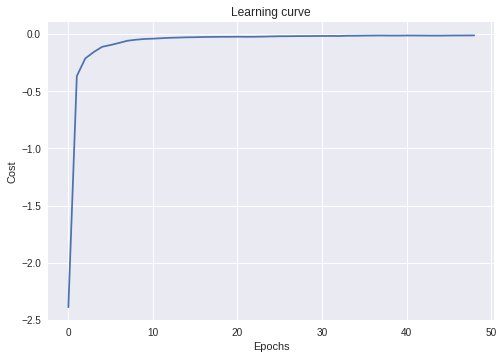

Test
28 28
(224, 224)
Saved samples.


In [0]:
train(50)


In [0]:
print (os.listdir("./drive/train"))

[]
